In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download alvinbintang/sibi-dataset

100% 2.69G/2.70G [00:24<00:00, 120MB/s]
100% 2.70G/2.70G [00:24<00:00, 120MB/s]


In [6]:
!unzip sibi-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: SIBI/B/1645946451.0243402_B.jpg  
  inflating: SIBI/B/1645946454.6260056_U.jpg  
  inflating: SIBI/B/1645946456.4885087_F.jpg  
  inflating: SIBI/B/1645946460.4972847_B.jpg  
  inflating: SIBI/B/1645946463.7729926_B.jpg  
  inflating: SIBI/B/1645946467.532869_B.jpg  
  inflating: SIBI/B/1645949132.0273714_B.jpg  
  inflating: SIBI/B/1645949136.465165_B.jpg  
  inflating: SIBI/B/1645949142.7455149_B.jpg  
  inflating: SIBI/B/1645949858.470701_Q.jpg  
  inflating: SIBI/B/1645949859.1649747_C.jpg  
  inflating: SIBI/B/1645949859.858002_Q.jpg  
  inflating: SIBI/B/1645949860.5160742_G.jpg  
  inflating: SIBI/B/1645949860.9303768_C.jpg  
  inflating: SIBI/B/1645949863.3891625_C.jpg  
  inflating: SIBI/B/1645949864.6113553_C.jpg  
  inflating: SIBI/B/1645950338.9793453_C.jpg  
  inflating: SIBI/B/1645950339.6984558_C.jpg  
  inflating: SIBI/B/1645950340.2939713_C.jpg  
  inflating: SIBI/B/1645950341.0949953_C.jpg  
  inflating: 

In [7]:
import datetime
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

**Creating Labels**

In [8]:
parent_folder_path = "/content/SIBI"

In [9]:
image_paths = []
class_labels = []

for subfolder_name in os.listdir(parent_folder_path):
  class_label = subfolder_name
  subfolder_path = os.path.join(parent_folder_path, subfolder_name)
  for image_name in os.listdir(subfolder_path):
        # get the full path to the image file
        image_path = os.path.join(subfolder_path, image_name)
        # append the image path and class label to the lists
        image_paths.append(image_path)
        class_labels.append(class_label)

data = {"image_path": image_paths, "class_label": class_labels}
df = pd.DataFrame(data)

In [10]:
df

,image_path,class_label
0,/content/SIBI/T/IMG_20220221_172349.jpg,T
1,/content/SIBI/T/IMG_20220224_174056.jpg,T
2,/content/SIBI/T/1645714487.1280842.jpg,T
3,/content/SIBI/T/1645950536.818242_O.jpg,T
4,/content/SIBI/T/1645716179.5821514.jpg,T
...,...,...
5275,/content/SIBI/U/1645712183.552852.jpg,U
5276,/content/SIBI/U/1645716081.4228492.jpg,U
5277,/content/SIBI/U/1645950548.0754035_U.jpg,U
5278,/content/SIBI/U/IMG_20220221_174045.jpg,U


In [11]:
# Get the list of subdirectories in the dataset directory (each subdirectory corresponds to a class)
class_names = os.listdir(parent_folder_path)

# Loop over the subdirectories and count the number of files in each one
for class_name in class_names:
    class_dir = os.path.join(parent_folder_path, class_name)
    num_images = len(os.listdir(class_dir))
    print("Class {}: {} images".format(class_name, num_images))

Class T: 220 images
Class S: 220 images
Class Y: 220 images
Class X: 220 images
Class M: 220 images
Class E: 220 images
Class D: 220 images
Class K: 220 images
Class A: 220 images
Class B: 220 images
Class N: 220 images
Class V: 220 images
Class Q: 220 images
Class P: 220 images
Class I: 220 images
Class L: 220 images
Class G: 220 images
Class F: 220 images
Class O: 220 images
Class H: 220 images
Class R: 220 images
Class W: 220 images
Class C: 220 images
Class U: 220 images


In [12]:
import concurrent.futures

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

8

In [16]:
# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((50,50)).convert("L"))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays
df

,image_path,class_label,image
0,/content/SIBI/T/IMG_20220221_172349.jpg,T,"[[166, 159, 156, 174, 168, 160, 164, 163, 167,..."
1,/content/SIBI/T/IMG_20220224_174056.jpg,T,"[[180, 180, 180, 181, 182, 182, 181, 181, 181,..."
2,/content/SIBI/T/1645714487.1280842.jpg,T,"[[153, 157, 156, 157, 157, 159, 160, 160, 160,..."
3,/content/SIBI/T/1645950536.818242_O.jpg,T,"[[152, 153, 153, 153, 151, 152, 153, 153, 151,..."
4,/content/SIBI/T/1645716179.5821514.jpg,T,"[[157, 159, 158, 157, 158, 159, 161, 162, 162,..."
...,...,...,...
5275,/content/SIBI/U/1645712183.552852.jpg,U,"[[155, 155, 156, 159, 158, 156, 158, 161, 159,..."
5276,/content/SIBI/U/1645716081.4228492.jpg,U,"[[169, 168, 169, 171, 171, 171, 170, 170, 172,..."
5277,/content/SIBI/U/1645950548.0754035_U.jpg,U,"[[150, 150, 150, 150, 150, 150, 151, 151, 151,..."
5278,/content/SIBI/U/IMG_20220221_174045.jpg,U,"[[79, 79, 80, 81, 82, 83, 83, 83, 84, 85, 87, ..."


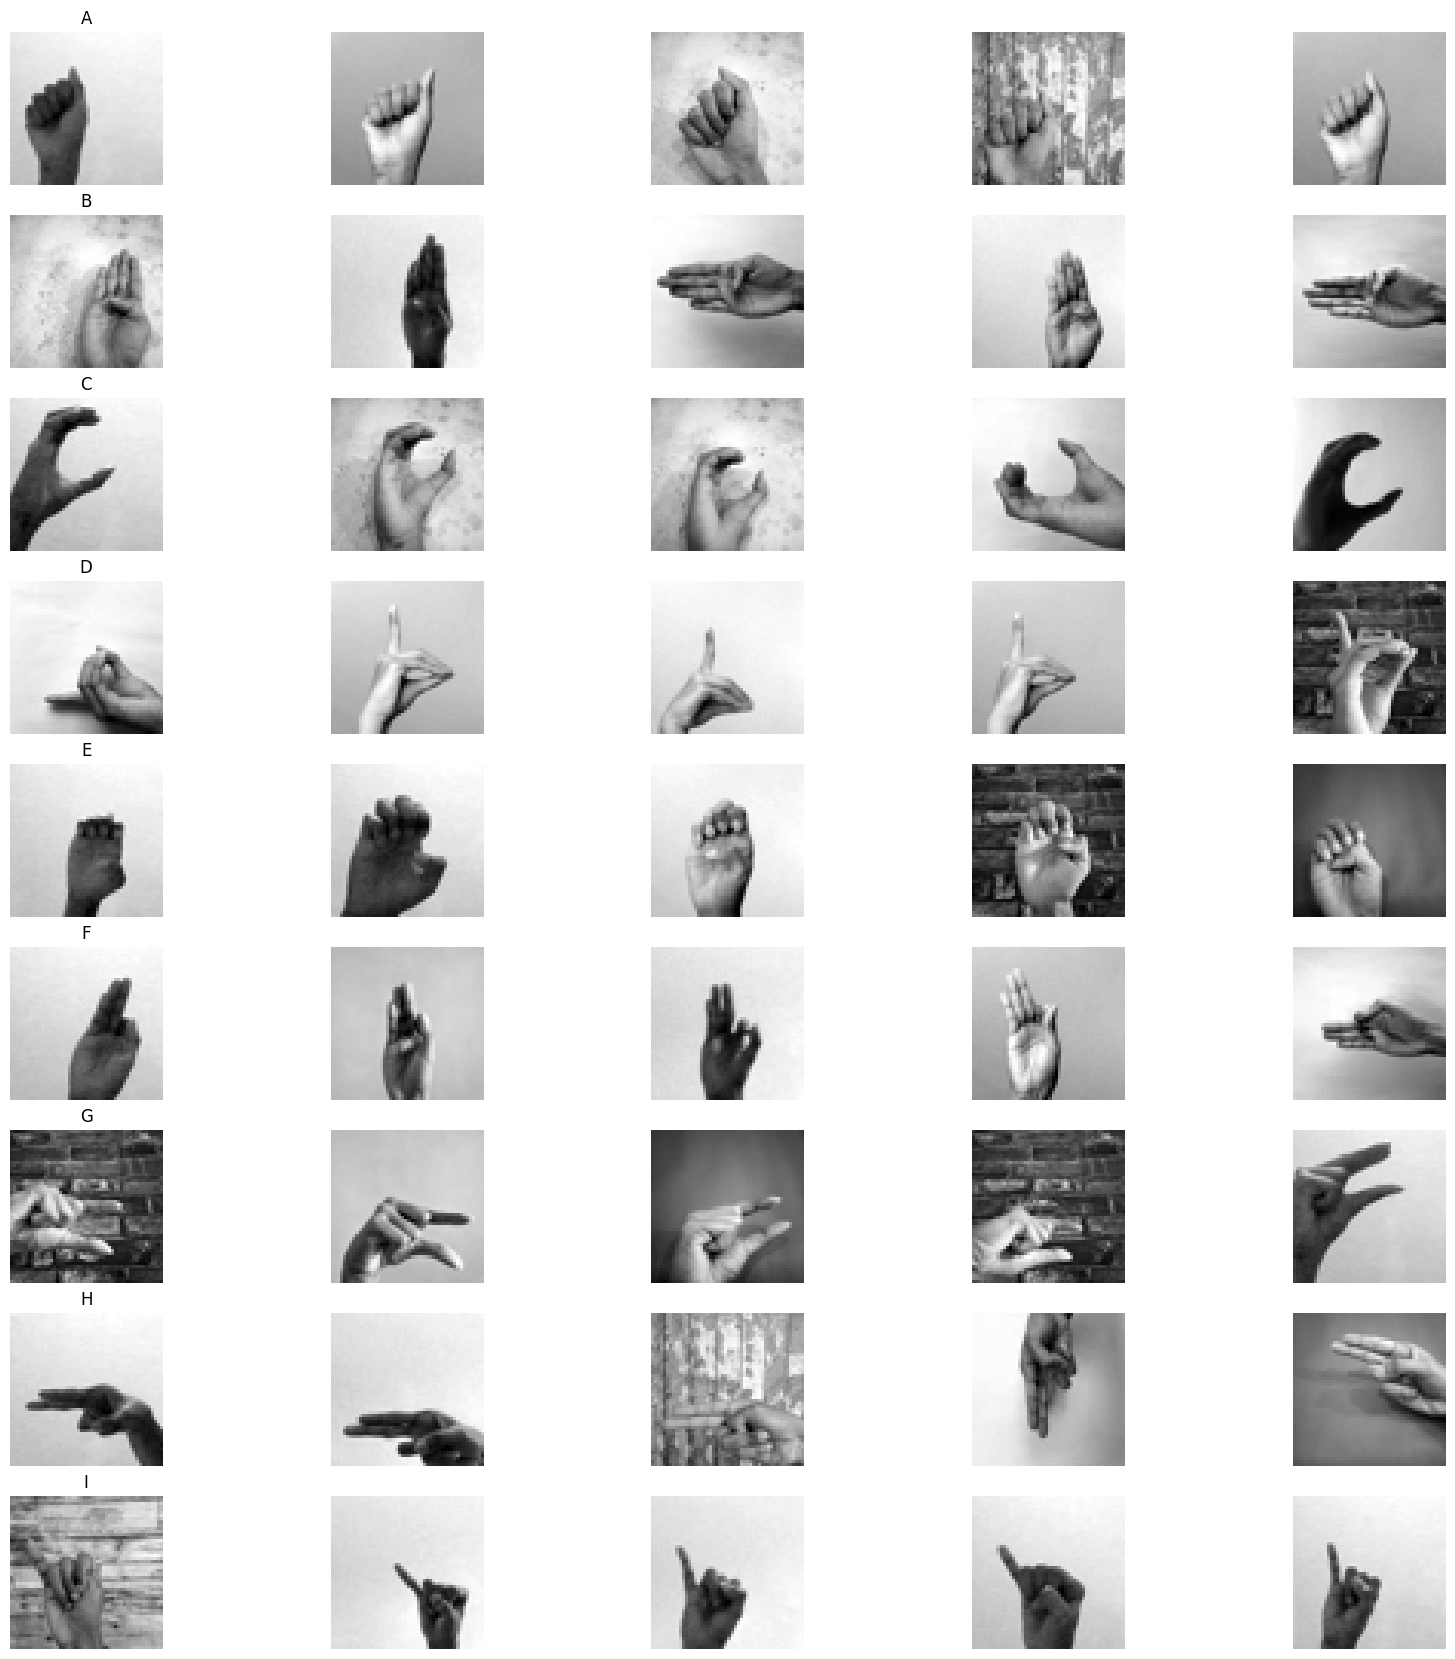

In [17]:
n_samples = 5
fig, m_axs = plt.subplots(9, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['class_label']).groupby('class_label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'], cmap='gray')
        c_ax.axis('off')

In [18]:
df['image'].map(lambda x: x.shape).value_counts()

(50, 50)    5280
Name: image, dtype: int64

In [19]:
features=df.drop(columns=['class_label','image_path'],axis=1)
target=df['class_label']

In [20]:
features.head()

,image
0,"[[166, 159, 156, 174, 168, 160, 164, 163, 167,..."
1,"[[180, 180, 180, 181, 182, 182, 181, 181, 181,..."
2,"[[153, 157, 156, 157, 157, 159, 160, 160, 160,..."
3,"[[152, 153, 153, 153, 151, 152, 153, 153, 151,..."
4,"[[157, 159, 158, 157, 158, 159, 161, 162, 162,..."


In [22]:
features.shape

(5280, 1)

In [21]:
target

0       T
1       T
2       T
3       T
4       T
       ..
5275    U
5276    U
5277    U
5278    U
5279    U
Name: class_label, Length: 5280, dtype: object

In [26]:
from sklearn.preprocessing import LabelEncoder
lbenc = LabelEncoder()
target = lbenc.fit_transform(target)

In [27]:
classes = lbenc.classes_

In [28]:
classes

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'],
      dtype=object)

In [29]:
print(target.shape,features.shape)

(5280,) (5280, 1)


In [30]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.10,random_state=1234)

In [31]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [32]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o,num_classes = 26)
y_test = to_categorical(y_test_o,num_classes = 26)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [34]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,50,50,1)
x_test = x_test.reshape(-1,50,50,1)
x_validate = x_validate.reshape(-1,50,50,1)

In [62]:
print(x_train.shape, x_validate.shape, x_test.shape)

(4276, 50, 50, 1) (476, 50, 50, 1) (528, 50, 50, 1)


In [35]:
# With data augmentation to prevent overfitting

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [36]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(125 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (50,50,1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
  tf.keras.layers.Conv2D(100 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
  tf.keras.layers.Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units = 512 , activation = 'relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(units = 26 , activation = 'softmax')
])

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 125)       1250      
                                                                 
 batch_normalization (Batch  (None, 50, 50, 125)       500       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 125)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 100)       112600    
                                                                 
 dropout (Dropout)           (None, 25, 25, 100)       0         
                                                                 
 batch_normalization_1 (Bat  (None, 25, 25, 100)       4

In [41]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = 128),
                    epochs = 35,
                    validation_data = (x_validate, y_validate))

Epoch 1/35
34/34 [==============================] - 2s 62ms/step - loss: 0.0976 - accuracy: 0.9705 - val_loss: 0.0692 - val_accuracy: 0.9769
Epoch 2/35
34/34 [==============================] - 2s 61ms/step - loss: 0.0983 - accuracy: 0.9675 - val_loss: 0.1056 - val_accuracy: 0.9580
Epoch 3/35
34/34 [==============================] - 2s 62ms/step - loss: 0.0944 - accuracy: 0.9661 - val_loss: 0.1585 - val_accuracy: 0.9370
Epoch 4/35
34/34 [==============================] - 2s 61ms/step - loss: 0.0833 - accuracy: 0.9724 - val_loss: 0.1126 - val_accuracy: 0.9685
Epoch 5/35
34/34 [==============================] - 2s 61ms/step - loss: 0.0687 - accuracy: 0.9759 - val_loss: 0.1429 - val_accuracy: 0.9496
Epoch 6/35
34/34 [==============================] - 2s 61ms/step - loss: 0.0886 - accuracy: 0.9698 - val_loss: 0.1608 - val_accuracy: 0.9559
Epoch 7/35
34/34 [==============================] - 2s 61ms/step - loss: 0.0926 - accuracy: 0.9687 - val_loss: 0.1123 - val_accuracy: 0.9685
Epoch 8/35
34

In [42]:
print("Accuracy of the model is - " , model.evaluate(x_validate,y_validate)[1]*100 , "%")

15/15 [==============================] - 0s 6ms/step - loss: 0.1215 - accuracy: 0.9580
Accuracy of the model is -  95.79831957817078 %


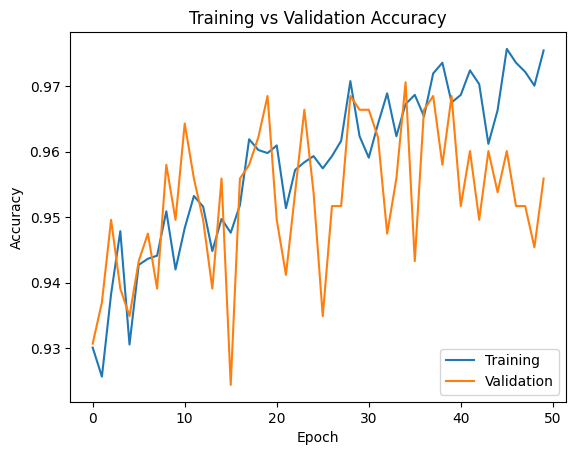

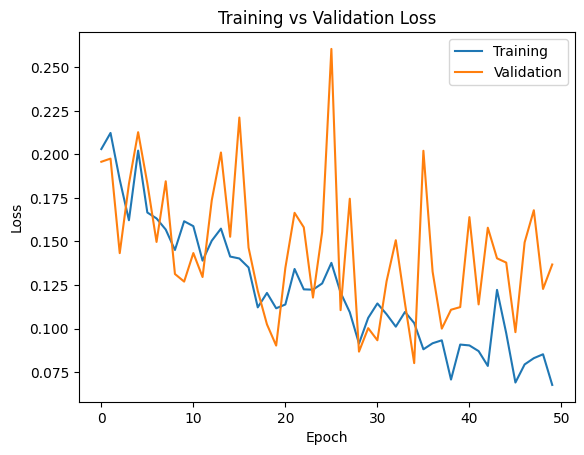

In [40]:
# Get training and testing accuracy and loss histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and testing accuracy curves
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Plot training and testing loss curves
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [43]:
predictions = model.predict(x_test)
import numpy as np
print(np.argmax(y_test[:20], axis=1))
print(np.argmax(predictions[:20], axis=1))

17/17 [==============================] - 0s 16ms/step
[22 19 23 14 14  2  6 11 21 19  8 16 11  6 17  7  7 13 19 20]
[22 19 23 14 14  2  6 11 21 19  8 16 11  6 17  7  7 13 19 20]


<Axes: >

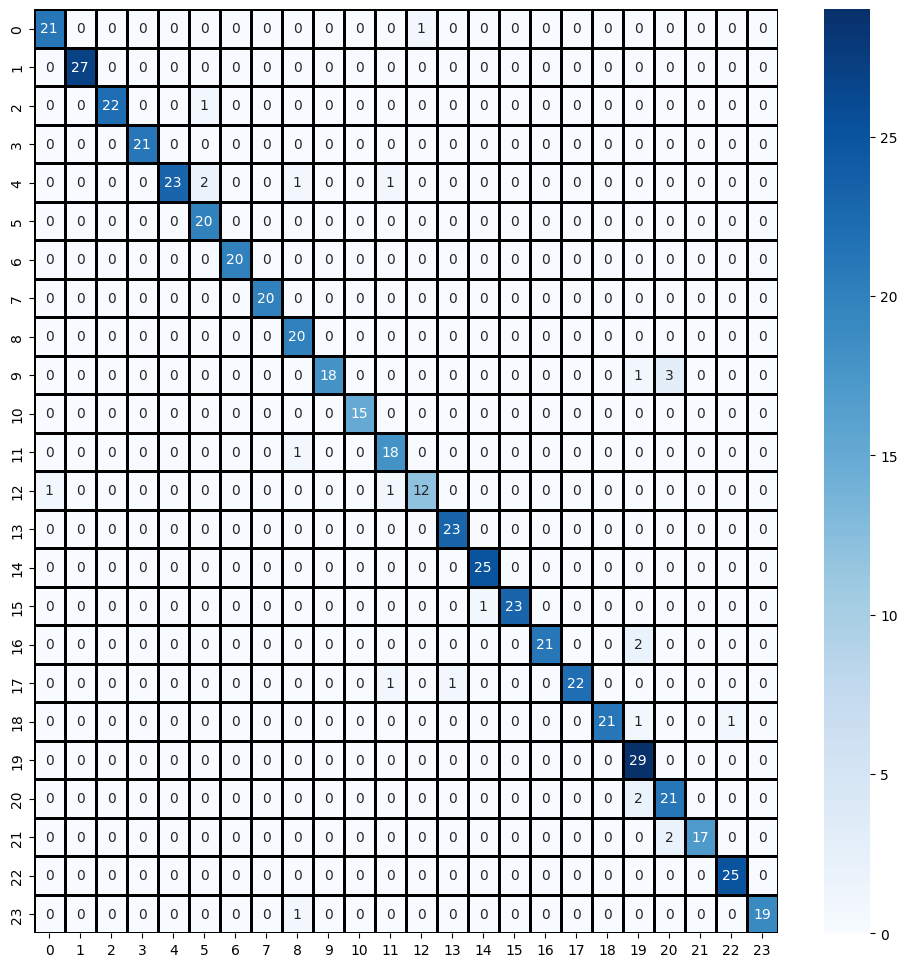

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize = (12,12))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [53]:
preds = np.argmax(predictions, axis=1)

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), preds)
precision = precision_score(np.argmax(y_test, axis=1), preds, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), preds, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9527
Precision: 0.9580
Recall: 0.9519


In [61]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=1), preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       1.00      1.00      1.00        27
           2       1.00      0.96      0.98        23
           3       1.00      1.00      1.00        21
           4       1.00      0.85      0.92        27
           5       0.87      1.00      0.93        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.87      1.00      0.93        20
           9       1.00      0.82      0.90        22
          10       1.00      1.00      1.00        15
          11       0.86      0.95      0.90        19
          12       0.92      0.86      0.89        14
          13       0.96      1.00      0.98        23
          14       0.96      1.00      0.98        25
          15       1.00      0.96      0.98        24
          16       1.00      0.91      0.95        23
          17       1.00    

In [55]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [56]:
saved_model_path = "/content/gdrive/MyDrive/TuturkuModel1.h5"

model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
